In [1]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
from keras.models import Model
import keras.backend as K
from keras.layers import Conv2D, Reshape, concatenate, LeakyReLU, BatchNormalization
import numpy as np
import math
from PIL import Image
import os, glob
import cv2
from keras.optimizers import Adam
from keras import regularizers

Using TensorFlow backend.


#### Origianl IncetopnResNetV2

In [2]:
RESmodel = InceptionResNetV2(include_top=True, weights='imagenet')

#### Origianl IncetopnResNetV2 structure to the last convolutional layer

In [3]:
inp = RESmodel.input
last_conv = RESmodel.get_layer('conv_7b_ac').output

#### Generate anchor

In [4]:
size_X = RESmodel.get_layer('conv_7b_ac').output_shape[1]
size_Y = RESmodel.get_layer('conv_7b_ac').output_shape[2]
rpn_stride = math.ceil(RESmodel.layers[0].output_shape[1]/RESmodel.get_layer('conv_7b_ac').output_shape[1])
scales = [8,16,32]     
ratios = [0.5,1,2]   

def anchor_gen(size_X,size_Y,rpn_stride,scales,ratios):
    scales , ratios = np.meshgrid(scales,ratios)
    scales,ratios = scales.flatten(),ratios.flatten()
    scalesY = scales*np.sqrt(ratios)
    scalesX = scales/np.sqrt(ratios)
    shiftX = np.arange(0,size_X)*rpn_stride
    shiftY = np.arange(0,size_Y)*rpn_stride
    shiftX,shiftY = np.meshgrid(shiftX,shiftY)
    centerX,anchorX = np.meshgrid(shiftX,scalesX)
    centerY,anchorY = np.meshgrid(shiftY,scalesY)
    anchor_center = np.stack([centerY,centerX],axis = 2).reshape(-1,2)
    anchor_size = np.stack([anchorY,anchorX],axis = 2).reshape(-1,2)
    boxes = np.concatenate([anchor_center-0.5*anchor_size,anchor_center+0.5*anchor_size],axis = 1)
    return boxes

In [5]:
anchors = anchor_gen(size_X,size_Y,rpn_stride,scales,ratios)
print(anchors.shape)

(576, 4)


In [6]:
def anno_corner2centerwh(anno2D):
    output = anno2D.copy()
    x = (anno2D[:,2]+anno2D[:,0])/2
    y = (anno2D[:,1]+anno2D[:,3])/2
    w = anno2D[:,2]-anno2D[:,0]
    h = anno2D[:,3]-anno2D[:,1]
    output[:,0] = x
    output[:,1] = y
    output[:,2] = w
    output[:,3] = h
    return output


def IoU(box1,box2):
    max_xmin = max(box1[0],box2[0])
    min_xmax = min(box1[2],box2[2])
    max_ymin = max(box1[1],box2[1])
    min_ymax = min(box1[3],box2[3])
    if max_xmin>=min_xmax or max_ymin>=min_ymax:
        return 0
    else:
        intersect_area = (min_xmax-max_xmin)*(min_ymax-max_ymin)
        box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
        box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
        iou = intersect_area/(box1_area+box2_area-intersect_area)
        return iou

"""
anno_array :
shape (N,5) , N is the number of bounding box
Each column is x_min, y_min, x_max, y_max, class
"""
def preprocessing_Y(anchors,anno_array):
    anchors_cfs_isValid = np.zeros((len(anchors)))
    anchors_cfs_isPosNeg = np.zeros((len(anchors)))
    groudT_box = np.zeros((len(anchors),5))

    iou_array = np.zeros((len(anchors),len(anno_array)))
    for i in range(len(anchors)):
        for j in range(len(anno_array)):
            iou_array[i,j] = IoU(anchors[i],anno_array[j])
    each_achor_maxiou = np.max(iou_array,axis = 1)
    
    positive_id = np.argwhere(each_achor_maxiou>=0.7)[:,0]
    positive_id = np.concatenate([positive_id,np.argmax(iou_array,axis=0)])
    positive_id = np.unique(positive_id)
    positive_id_mapping_which_groundTbox = np.argmax(iou_array[positive_id],axis=1)
    
    groudT_box[positive_id] = anno_array[positive_id_mapping_which_groundTbox]
    
    negative_id = np.argwhere(each_achor_maxiou<=0.3)[:,0]

    anchors_cfs_isPosNeg[positive_id] = 1
    anchors_cfs_isValid[np.concatenate([positive_id,negative_id])] = 1
    
    # columns = [anchor is valid for training, anchor is postive or negative, [x1, y1, x2, y2]], shape = [N_anchors, 6]
    groudT_box_xywh = anno_corner2centerwh(groudT_box[:,:4])
    
    # 除以圖片寬高 標準化縮放到01區間
    groudT_box_xywh[:,:4] = groudT_box_xywh[:,:4]/np.array(K.int_shape(inp)[1:3]*2)
    
    cfs_reg_output = np.c_[anchors_cfs_isValid,anchors_cfs_isPosNeg, groudT_box_xywh]
    
    # class of each box
    cls_output = groudT_box[:,4]
    return [cfs_reg_output,cls_output]

#### RPN structure

In [7]:
num_anchors = len(scales)*len(ratios)
rpn = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv')(last_conv)
rpn_confidence = Conv2D(num_anchors*2, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_confidence')(rpn)
rpn_confidence = Reshape((-1,2), name='confidence_reshape')(rpn_confidence)
rpn_reg = Conv2D(num_anchors*4, (1, 1)
                 , activation = 'sigmoid'
                 , name='rpn_out_regress')(rpn)
rpn_reg = Reshape((-1,4), name='regress_reshape')(rpn_reg)
rpn_output = concatenate([rpn_confidence,rpn_reg],axis=2, name='rpn_final_output')

# Loss function for RPN network

In [8]:
def rpn_loss(num_anchors,anchors):
    
    def rpn_loss_fixed_num(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        y_pred = K.cast(y_pred, tf.float32)
        
        Nreg = K.cast((K.shape(y_pred)[0]*K.shape(y_pred)[1]/num_anchors), tf.float32)
        Ncls = K.cast(K.sum(y_true[:,:,0]), tf.float32)
        Lambda = Nreg/Ncls
        anchor_tensor = K.cast(anno_corner2centerwh(anchors), tf.float32)
        
        # Regression part
        tx = K.expand_dims((y_true[:,:,2]-anchor_tensor[:,0])/(anchor_tensor[:,2]+K.epsilon()),2)
        ty = K.expand_dims((y_true[:,:,3]-anchor_tensor[:,1])/(anchor_tensor[:,3]+K.epsilon()),2)
        tw = K.expand_dims(K.log(y_true[:,:,4]/(anchor_tensor[:,2]+K.epsilon())+K.epsilon()),2)
        th = K.expand_dims(K.log(y_true[:,:,5]/(anchor_tensor[:,3]+K.epsilon())+K.epsilon()),2)
        tx_star = K.expand_dims((y_pred[:,:,2]-anchor_tensor[:,0])/(anchor_tensor[:,2]+K.epsilon()),2)
        ty_star = K.expand_dims((y_pred[:,:,3]-anchor_tensor[:,1])/(anchor_tensor[:,3]+K.epsilon()),2)
        tw_star = K.expand_dims(K.log(y_pred[:,:,4]/(anchor_tensor[:,2]+K.epsilon())+K.epsilon()),2)
        th_star = K.expand_dims(K.log(y_pred[:,:,5]/(anchor_tensor[:,3]+K.epsilon())+K.epsilon()),2)

        t_true = K.concatenate([tx,ty,tw,th],axis=2)
        t_pred = K.concatenate([tx_star,ty_star,tw_star,th_star],axis=2)
        
        x = t_true - t_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)
        
        smooth_fun = x_bool*(0.5*(x**2)) + (1-x_bool)*(x_abs - 0.5)
        
        reg_loss = Lambda * K.sum(K.expand_dims(y_true[:,:,0] * y_true[:,:,1],2) * smooth_fun) / (Nreg+K.epsilon())
        
        # Confidence part
        cfs_loss = K.sum(K.binary_crossentropy(
            # 這部分可以改一下讓前景跟背景的比例為1:1
            y_true[:,:,0]*y_true[:,:,1], y_true[:,:,0]*y_pred[:,:,1]
        ))  / (Ncls+K.epsilon())
        
        return reg_loss+cfs_loss
    
    
    return rpn_loss_fixed_num

In [9]:
RPN_network = Model(inp, rpn_output)
# RPN_network.summary()

In [10]:
opt = Adam(lr=0.0001)
RPN_network.compile(optimizer=opt, loss=rpn_loss(num_anchors,anchors))

### Read annotation file

In [11]:
f = open("RiceDataSet/annotation.txt", "r")
anno_file = []
for i in f:
    anno_file.append(i.replace("\n",""))

In [12]:
def train_batch_generator(anno_file, anchor, num_files):
    start=0
    while True:
        end=start+num_files
        if end>len(anno_file) :
            partial=anno_file[start:]
            partial.extend(anno_file[:end-len(anno_file)])
        else :
            partial=anno_file[start:end]

        split_space = [i.split(" ") for i in partial]

        X_img=[]
        input_shape_list = []
        for im_path in ['RiceDataSet/'+i[0] for i in split_space]:
            temp_img = np.array(Image.open(im_path))
            input_shape_list.append(temp_img.shape)
            temp_img = cv2.resize(temp_img,(299,299))
            X_img.append(temp_img)
        X_img=np.array(X_img)


        anno_array_each_X = []
        for nnn,i in enumerate(split_space):
            temp = []
            for j in i[1:]:
                temp.append(j.split(","))
            temp = np.array(temp).astype(int)
            temp[:,0] = temp[:,0]*299/input_shape_list[nnn][1] # width, X
            temp[:,2] = temp[:,2]*299/input_shape_list[nnn][1] # width, X
            temp[:,1] = temp[:,1]*299/input_shape_list[nnn][0] # height, Y
            temp[:,3] = temp[:,3]*299/input_shape_list[nnn][0] # height, Y           
            anno_array_each_X.append(
                temp
            )

        Y_for_rpn = np.array([preprocessing_Y(anchors,i)[0] for i in anno_array_each_X])

        yield X_img,Y_for_rpn

        if(end>=len(anno_file)):
            start=0
            np.random.shuffle(anno_file)
        else:
            start=start+len(partial)

In [ ]:
train_batch_size = 35
RPN_network.fit_generator(train_batch_generator(anno_file = anno_file, anchor = anchors, num_files = train_batch_size),
                    steps_per_epoch = math.floor(len(anno_file)/train_batch_size),
                    epochs=200)

Epoch 1/200
39/39 [==============================] - 160s 4s/step - loss: 0.3053
Epoch 2/200
39/39 [==============================] - 157s 4s/step - loss: 0.1612
Epoch 3/200
39/39 [==============================] - 158s 4s/step - loss: 0.1328
Epoch 4/200
39/39 [==============================] - 158s 4s/step - loss: 0.1234
Epoch 5/200
39/39 [==============================] - 158s 4s/step - loss: 0.1191
Epoch 6/200
39/39 [==============================] - 158s 4s/step - loss: 0.1146
Epoch 7/200
39/39 [==============================] - 158s 4s/step - loss: 0.1114
Epoch 8/200
39/39 [==============================] - 157s 4s/step - loss: 0.1075
Epoch 9/200
39/39 [==============================] - 158s 4s/step - loss: 0.1046
Epoch 10/200
39/39 [==============================] - 160s 4s/step - loss: 0.1010
Epoch 11/200
39/39 [==============================] - 156s 4s/step - loss: 0.0975
Epoch 12/200
39/39 [==============================] - 157s 4s/step - loss: 0.0940
Epoch 13/200
39/39 [=====

In [14]:
predict_input = "RiceDataSet/"+np.random.choice(anno_file).split(" ")[0]
predict_input = cv2.resize(cv2.imread(predict_input),(299,299))
predict_input = np.expand_dims(predict_input,0)
predict_output = RPN_network.predict(predict_input)

In [15]:
is_object = np.argwhere(predict_output[0][:,1]>0.3)[:,0]
is_object

array([146, 147, 160, 355, 529, 530, 532, 537, 566])

In [16]:
import matplotlib.pyplot as plt
plt.imshow(predict_input[0])

In [17]:
def draw_box_img(img,box_info_df):
    for i in range(len(box_info_df)):
        img = cv2.line(img,tuple(box_info_df[['xmin','ymin']].iloc[i]),tuple(box_info_df[['xmin','ymax']].iloc[i]),(0,0,255),3)
        img = cv2.line(img,tuple(box_info_df[['xmax','ymin']].iloc[i]),tuple(box_info_df[['xmax','ymax']].iloc[i]),(0,0,255),3)
        img = cv2.line(img,tuple(box_info_df[['xmin','ymin']].iloc[i]),tuple(box_info_df[['xmax','ymin']].iloc[i]),(0,0,255),3)
        img = cv2.line(img,tuple(box_info_df[['xmin','ymax']].iloc[i]),tuple(box_info_df[['xmax','ymax']].iloc[i]),(0,0,255),3)
    return img[...]

In [28]:
import pandas as pd
box_info_df = pd.DataFrame(predict_output[0][is_object,2:]*299)
xmin = box_info_df[0]-box_info_df[2]/2
ymin = box_info_df[1]-box_info_df[3]/2
xmax = box_info_df[0]+box_info_df[2]/2
ymax = box_info_df[1]+box_info_df[3]/2
box_info_df = pd.DataFrame({'xmin':xmin.astype(int),'ymin':ymin.astype(int),'xmax':xmax.astype(int),'ymax':ymax.astype(int)})

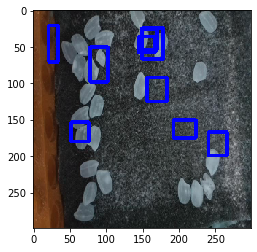

In [30]:
plt.imshow(draw_box_img(predict_input[0],box_info_df))